In [1]:
cd /orange/adamginsburg/jwst/brick/

/orange/adamginsburg/jwst/brick


In [133]:
from astropy import coordinates

In [2]:
import numpy as np

In [3]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [4]:
import regions

In [5]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [6]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [7]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)

In [8]:
import glob
from astropy.io import fits

In [9]:
catfns = glob.glob("F*/f[0-9][0-9][0-9][nm]*nrca_crowdsource.fits")
catfns

['F410M/f410m_nrca_crowdsource.fits',
 'F212N/f212n_nrca_crowdsource.fits',
 'F466N/f466n_nrca_crowdsource.fits',
 'F405N/f405n_nrca_crowdsource.fits',
 'F187N/f187n_nrca_crowdsource.fits',
 'F182M/f182m_nrca_crowdsource.fits']

In [10]:
wcses = [wcs.WCS(fits.getheader(fn.replace("_crowdsource", "_crowdsource_skymodel"))) for fn in catfns]

Set DATE-AVG to '2022-08-28T03:05:31.909' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.654832 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526328725.126 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-08-28T02:01:42.809' from MJD-AVG.
Set DATE-END to '2022-08-28T02:29:48.969' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.686401 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526699842.678 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-08-28T02:01:42.785' from MJD-AVG.
Set DATE-END to '2022-08-28T02:29:48.969' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.690472 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526747727.686 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-08-28T00:59:05.244' from MJD-AVG.
Set DATE-END to '2022-08-28T01:27:10.957' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.722509 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527124813.495 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE

In [11]:
tbls = [Table.read(catfn) for catfn in catfns]
for catfn, tbl in zip(catfns, tbls):
    tbl.meta['filename'] = catfn
    tbl.meta['filter'] = os.path.basename(catfn).split("_")[0]
for tbl, ww in zip(tbls, wcses):
    tbl['y'],tbl['x'] = tbl['x'],tbl['y']
    crds = ww.pixel_to_world(tbl['x'], tbl['y'])
    tbl.add_column(crds, name='skycoords')
    tbl.meta['pixelscale'] = ww.proj_plane_pixel_area()
    flux_jy = (tbl['flux'] * u.MJy/u.sr * (2*np.pi / (8*np.log(2))) * tbl['fwhm']**2 * tbl.meta['pixelscale']).to(u.Jy)
    abmag = flux_jy.to(u.ABmag)
    tbl.add_column(flux_jy, name='flux_jy')
    tbl.add_column(abmag, name='mag_ab')

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/blue/adamginsburg/adamginsburg/repos/astropy/astropy/u

In [75]:
basepath = '/orange/adamginsburg/jwst/brick/'
reg = regions.Regions.read(f'{basepath}/regions/leftside_brick_zoom.reg')[0]
regzoom = regions.Regions.read(f'{basepath}/regions/leftside_brick_rezoom.reg')[0]

(266.5349675273957,
 266.5434811600702,
 -28.750865417692577,
 -28.743970507368118)

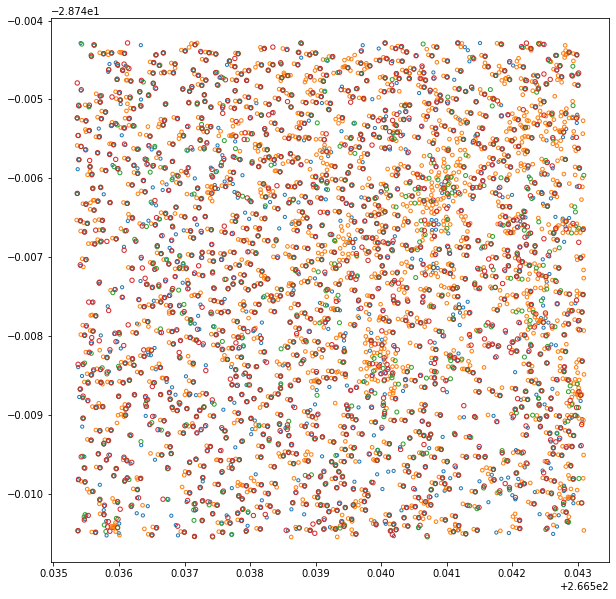

In [13]:
pl.figure(figsize=(10,10))
ax = pl.gca()
for ii, (ww, tbl) in enumerate(zip(wcses, tbls)):
    crds = tbl['skycoords']
    crds = crds[reg.contains(crds, ww)]
    markers = ax.scatter(crds.ra, crds.dec, s=10+3*ii)
    markers.set_edgecolors(markers.get_facecolors())
    markers.set_facecolors('none')
ax.axis()

In [14]:
tbl[:5]

x,y,flux,passno,dx,dy,dflux,qf,rchi2,fracflux,fluxlbs,dfluxlbs,fwhm,spread_model,dspread_model,fluxiso,xiso,yiso,sky,skycoords,flux_jy,mag_ab
,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,mag(AB)
float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32
141.40467953681946,-0.499,-13157733.0,0.0,6.1509774e-05,6.778127e-05,428.09622,0.015456498,24316830.0,-193.44972,27833.803,620.5224,2.6851454,0.050452888,1.3789332e-05,-2583373.5,0.18504900181874592,1.209561064244098,-5.129453,"266.53406070133747,-28.742627134844646",-2.4148476,nan
170.30779406428337,0.3469894528388977,7285191.5,0.0,8.7281565e-05,9.134815e-05,315.27194,0.018820843,10495679.0,336.0895,1317346.6,459.8154,2.6825068,0.024132252,4.7418175e-06,3292189.5,0.6427378345019326,0.04625276259917602,-5.141512,"266.5340650512557,-28.742378846546046",1.3344295,8.5867605
176.79638289503362,-0.499,-8792183.0,0.0,8.6803266e-05,9.8894685e-05,405.29013,0.015473098,8352629.0,-306.68454,-1803946.0,571.2375,2.6813407,0.023189723,6.542249e-06,-4884370.5,-0.24520002116956524,-0.12148671461347987,-5.1444225,"266.53405588258755,-28.742323230866397",-1.6090657,nan
1115.3221502900124,-0.499,532064.75,0.0,2.5231642e-05,8.053608e-05,23.694345,0.17636885,79144320.0,-105.38675,-49155.88,24.583889,2.683648,0.058696628,5.602953e-05,-67124.43,-0.19998281526367717,1.7544726578798913,-5.8250504,"266.5339281080344,-28.734264231208435",0.09754132,11.427029
1120.055519234389,-0.499,428622.0,0.0,2.9415047e-05,8.9921865e-05,22.471828,0.17636353,64291348.0,-143.3766,-46553.633,23.191257,2.6786249,-0.013562679,3.3236796e-05,-195462.88,-0.4248809556546224,-0.5375015667936942,-5.8107023,"266.53392746366507,-28.73422358637888",0.07828368,11.665822


In [15]:
tbls[0].meta['filter'], len(tbls[0])

('f410m', 75555)

In [16]:
basetable = tbls[0].copy()
basecrds = basetable['skycoords']
for colname in basetable.colnames:
    basetable.rename_column(colname, colname+"_"+basetable.meta['filter'])
#basetable = basetable[[cn for cn in basetable.colnames if not any(x in cn for x in ignored_columns)]]

for tbl in tbls[1:]:
    wl = tbl.meta['filter']
    print(wl)
    #tbl = tbl[[cn for cn in tbl.colnames if not any(x in cn for x in ignored_columns)]]
    crds = tbl['skycoords']
    matches, sep, _ = basecrds.match_to_catalog_sky(crds, nthneighbor=1)
    basetable.add_column(name=f"sep_{wl}", col=sep)
    basetable.add_column(name=f"id_{wl}", col=matches)
    matchtb = tbl[matches]
    for cn in matchtb.colnames:
        #matchtb[cn][sep > 0.1*u.arcsec].mask = True
        matchtb.rename_column(cn, f"{cn}_{wl}")
    basetable = table.hstack([basetable, matchtb], join_type='exact')
    basetable.meta[f'{wl}_pixelscale'] = tbl.meta['pixelscale']
    #if 'sky_centroid_f444w' in basetable.colnames:
    #    basetable.rename_column('sky_centroid_f444w', 'sky_centroid')
    #basetable = table.join(basetable, tbl,
    #                      table_names=['', wl],
    #                      join_type='outer',
    #                      join_funcs={'sky_centroid': table.join_skycoord(0.1*u.arcsec)})
    #if 'sky_centroid_' in basetable.colnames:
    #    basetable.rename_column('sky_centroid_', 'sky_centroid_f444w')
    basetable.write(f"{basepath}/catalogs/crowdsource_nrca_photometry_tables_merged.ecsv", overwrite=True)
    basetable.write(f"{basepath}/catalogs/crowdsource_nrca_photometry_tables_merged.fits", overwrite=True)

f212n


f466n


f405n


f187n


f182m


In [17]:
len(basetable)

75555

In [18]:
basetable[reg.contains(basetable['skycoords_f405n'],ww)][:5]

x_f410m,y_f410m,flux_f410m,passno_f410m,dx_f410m,dy_f410m,dflux_f410m,qf_f410m,rchi2_f410m,fracflux_f410m,fluxlbs_f410m,dfluxlbs_f410m,fwhm_f410m,spread_model_f410m,dspread_model_f410m,fluxiso_f410m,xiso_f410m,yiso_f410m,sky_f410m,skycoords_f410m,flux_jy_f410m,mag_ab_f410m,sep_f212n,id_f212n,x_f212n,y_f212n,flux_f212n,passno_f212n,dx_f212n,dy_f212n,dflux_f212n,qf_f212n,rchi2_f212n,fracflux_f212n,fluxlbs_f212n,dfluxlbs_f212n,fwhm_f212n,spread_model_f212n,dspread_model_f212n,fluxiso_f212n,xiso_f212n,yiso_f212n,sky_f212n,skycoords_f212n,flux_jy_f212n,mag_ab_f212n,sep_f466n,id_f466n,x_f466n,y_f466n,flux_f466n,passno_f466n,dx_f466n,dy_f466n,dflux_f466n,qf_f466n,rchi2_f466n,fracflux_f466n,fluxlbs_f466n,dfluxlbs_f466n,fwhm_f466n,spread_model_f466n,dspread_model_f466n,fluxiso_f466n,xiso_f466n,yiso_f466n,sky_f466n,skycoords_f466n,flux_jy_f466n,mag_ab_f466n,sep_f405n,id_f405n,x_f405n,y_f405n,flux_f405n,passno_f405n,dx_f405n,dy_f405n,dflux_f405n,qf_f405n,rchi2_f405n,fracflux_f405n,fluxlbs_f405n,dfluxlbs_f405n,fwhm_f405n,spread_model_f405n,dspread_model_f405n,fluxiso_f405n,xiso_f405n,yiso_f405n,sky_f405n,skycoords_f405n,flux_jy_f405n,mag_ab_f405n,sep_f187n,id_f187n,x_f187n,y_f187n,flux_f187n,passno_f187n,dx_f187n,dy_f187n,dflux_f187n,qf_f187n,rchi2_f187n,fracflux_f187n,fluxlbs_f187n,dfluxlbs_f187n,fwhm_f187n,spread_model_f187n,dspread_model_f187n,fluxiso_f187n,xiso_f187n,yiso_f187n,sky_f187n,skycoords_f187n,flux_jy_f187n,mag_ab_f187n,sep_f182m,id_f182m,x_f182m,y_f182m,flux_f182m,passno_f182m,dx_f182m,dy_f182m,dflux_f182m,qf_f182m,rchi2_f182m,fracflux_f182m,fluxlbs_f182m,dfluxlbs_f182m,fwhm_f182m,spread_model_f182m,dspread_model_f182m,fluxiso_f182m,xiso_f182m,yiso_f182m,sky_f182m,skycoords_f182m,flux_jy_f182m,mag_ab_f182m
,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,mag(AB),deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,mag(AB),deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,mag(AB),deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,mag(AB),deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,mag(AB),deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,mag(AB)
float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32
687.1257168736004,1120.1790723978697,1916.9683,0.0,0.0005626767,0.000460884,0.84606856,1.0,3640.7031,0.8458984,2013.4742,0.8890487,3.1254942,0.0030514002,3.5411234e-05,1872.5781,0.16590431586111226,-0.08963082849201051,12.08455,"266.5353710136,-28.75047825329775",0.001973598,15.661854,4.773283598999825e-05,231,1417.3163606644873,105.2869462273995,4957.119,0.0,0.037380695,0.03703569,104.02648,1.0,5.5826426,0.9878566,3947.9753,106.679794,2.9770222,0.012981057,0.00094739563,4964.9795,0.007692691119873001,0.04147562522385796,-53.40271,"266.5353187046587,-28.75046501533882",0.0011087551,16.28791,8.688181542176019e-06,26680,687.1485109896793,1120.7379445419472,1267.4857,0.0,0.014018612,0.0125839,11.46506,1.0,3.8918197,0.8156338,1276.259,11.803201,3.2520468,0.004059732,0.00057080813,1264.5741,0.02640536193199002,-0.03008230647921292,13.222425,"266.53537561811

In [19]:
basetable[reg.contains(basetable['skycoords_f410m'],ww)][:5]['flux_f410m', 'skycoords_f410m', 'x_f410m', 'y_f410m']

flux_f410m,skycoords_f410m,x_f410m,y_f410m
,"deg,deg",,
float32,SkyCoord,float64,float64
1916.9683,"266.5353710136,-28.75047825329775",687.1257168736004,1120.1790723978697
347.00195,"266.5353736394302,-28.74983023401781",724.2031165430246,1120.924756279685
32.806828,"266.5353932297251,-28.748775101113825",784.5614139326536,1122.9072088464861
40.120964,"266.5353774824147,-28.748396187731387",806.2558698350401,1122.476213735101
93.08459,"266.535403639173,-28.74867360545401",790.3603358579077,1123.5255794001594


In [20]:
#(500*u.Jy).to(u.ABmag)
(basetable[reg.contains(basetable['skycoords_f410m'],ww)][:5]['flux_f410m'] * u.Jy).to(u.ABmag)

<Magnitude [0.6934626, 2.5491703, 5.1100893, 4.8915715, 3.9778054] mag(AB)>

In [21]:
tbls[5][20:30]

x,y,flux,passno,dx,dy,dflux,qf,rchi2,fracflux,fluxlbs,dfluxlbs,fwhm,spread_model,dspread_model,fluxiso,xiso,yiso,sky,skycoords,flux_jy,mag_ab
,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,mag(AB)
float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32
1930.356159644282,5.268115050982947,-4173.4233,0.0,0.00072913495,0.0007884737,2.534319,0.9809736,248696.53,1.1201949,-162.13336,2.6026747,2.6824834,0.037666857,0.0004120893,518.7026,-0.22738014158626843,-0.057524194488789274,-5.317006,"266.53387363432716,-28.727264950641374",-0.0007644332,nan
2365.405321275693,4.959547121039538,-1283.2921,0.0,0.0021468867,0.0020678078,1.5407072,0.9799944,105981.34,0.9999685,141.73088,1.592774,2.6787605,0.008590639,0.00027570105,239.13368,0.35234290877314217,0.03002204906691067,-4.970781,"266.53381139621257,-28.723529276272377",-0.00023440468,nan
2529.909709444335,4.333611399350384,-710.3747,0.0,0.0036527857,0.003440202,1.4906305,0.9744742,77697.3,-0.6733995,3376.1306,1.5476626,2.6788921,0.12572551,0.0033521065,-58.421608,2.9899118987201594,3.1643715775918233,-5.7137876,"266.53378287692226,-28.722116772959865",-0.00012976899,nan
27.66298633813858,6.515789806842804,255205460000000.0,0.0,1e+20,1e+20,10000000000.0,0.0,0.0,0.0,0.0,0.0,2.6845958,0.0,0.0,0.0,0.0,0.0,-5.1018014,"266.53414488831817,-28.743602982600034",46818852.0,-10.2760515
1243.6374587841015,6.6087616155721705,-763.04584,0.0,0.0040122257,0.0042248107,2.2997231,0.9894836,16270.409,1.2308601,-23.148535,2.3679667,2.684648,0.04308629,0.0005525137,282.56934,0.2697955942782296,0.06973849856013976,-6.097042,"266.53398024411445,-28.733161555716197",-0.00013999043,nan
1771.6592319443607,7.521162204966377,-2486.1106,0.0,0.0010464343,0.00093611877,1.406978,0.99544895,361687.88,1.2458223,-30.52297,1.4372622,2.6848807,0.049038947,0.00042178022,214.59683,0.03183513404752536,-0.43980990794960517,-5.688507,"266.53391729877245,-28.728627391804178",-0.00045618758,nan
1848.1073345782568,6.433355089676691,4142.258,0.0,0.00052009727,0.00054016564,1.3158594,0.9861039,993685.4,0.071950585,85.43136,1.3507977,2.6807203,-0.31316745,0.01143716,21.672544,-0.1614613838051054,-29.47258506044582,-5.4296913,"266.5338962403303,-28.727971071631696",0.0007577277,16.701218
1851.8245788885392,6.1681004748210775,4625.3613,0.0,0.00048391856,0.0005197,1.5212811,0.9856833,912562.2,-0.4098268,-155.44954,1.5623797,2.6764789,0.05259484,0.00053127855,-213.81569,-0.48560801420147903,-2.897332940830144,-5.416069,"266.53389313691105,-28.727939183795723",0.00084342464,16.584885


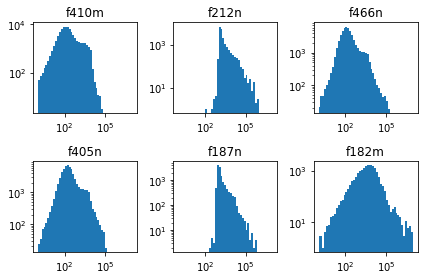

In [22]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['flux'], bins=np.logspace(0,7), log=True)
    ax.set_title(tbl.meta['filter'])
    ax.loglog()
pl.tight_layout()

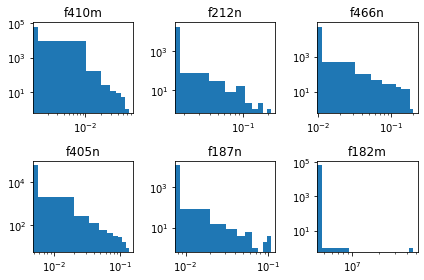

In [23]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['flux_jy'], log=True)
    ax.set_title(tbl.meta['filter'])
    ax.loglog()
pl.tight_layout()

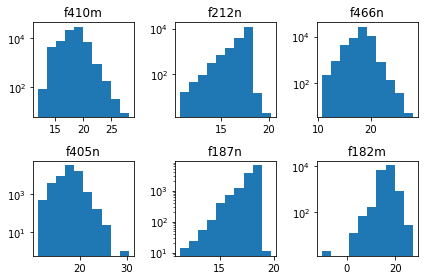

In [24]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['mag_ab'], log=True)
    ax.set_title(tbl.meta['filter'])
    #ax.loglog()
pl.tight_layout()

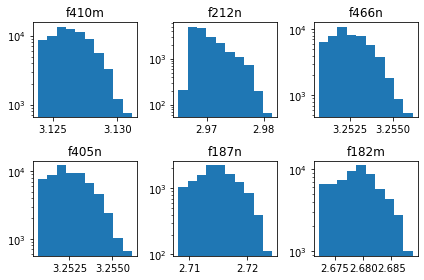

In [25]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['fwhm'], log=True)
    ax.set_title(tbl.meta['filter'])
pl.tight_layout()

# XMatch Check

In [96]:
len(tbls[0]), tbls[0].meta['filter']

(75555, 'f410m')

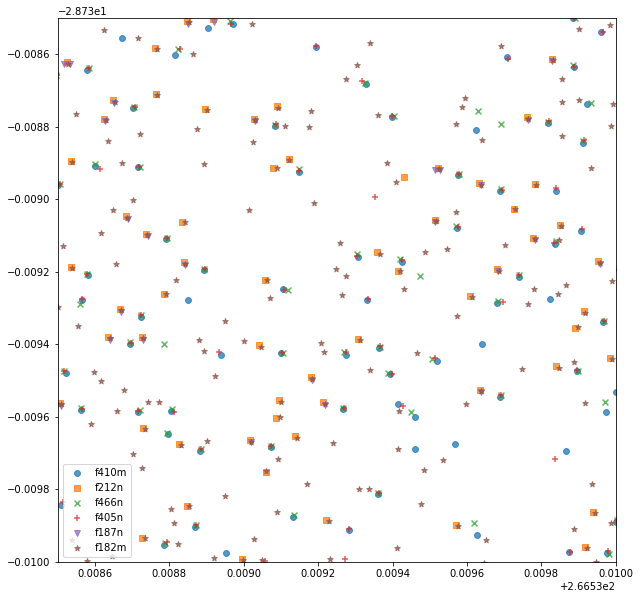

In [99]:
pl.figure(figsize=(10,10))
for tbl,marker in zip(tbls, 'osx+v*'):
    crds = tbl['skycoords']
    pl.scatter(crds.ra, crds.dec, alpha=0.75, s=35,
               marker=marker, label=tbl.meta['filter'])
pl.axis((266.5385, 266.54, -28.740, -28.7385))
pl.legend(loc='best')

# Color-magnitude and color-color diagrams

(25.0, 13.0)

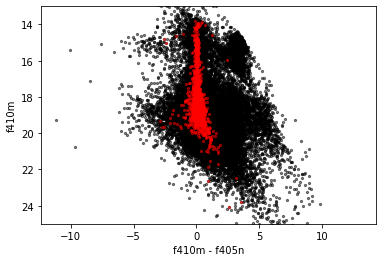

In [106]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f405n")
pl.ylabel("f410m")
pl.ylim(25,13)

(25.0, 14.0)

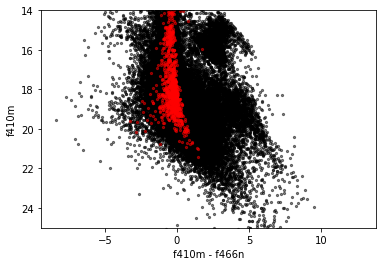

In [107]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f466n")
pl.ylabel("f410m")
pl.ylim(25,14)

(-5.0, 10.0, -5.0, 10.0)

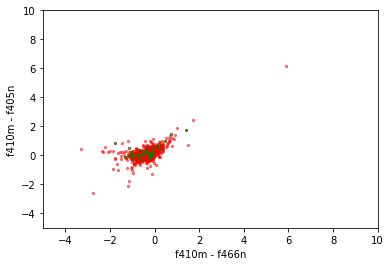

In [109]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
sel2 = regzoom.contains(basetable['skycoords_f410m'], ww)
sel2 &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel2 &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
#pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m']-basetable['mag_ab_f405n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel], s=5, alpha=0.5, c='r')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel2], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel2], s=5, alpha=0.5, c='g')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f466n")
pl.ylabel("f410m - f405n")
pl.axis((-5,10,-5,10))

(25.0, 14.0)

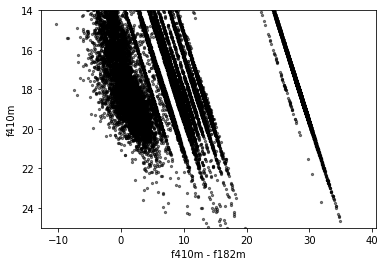

In [112]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f182m'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f182m'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f182m'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.xlabel("f410m - f182m")
pl.ylabel("f410m")
pl.ylim(25,14)

(25.0, 14.0)

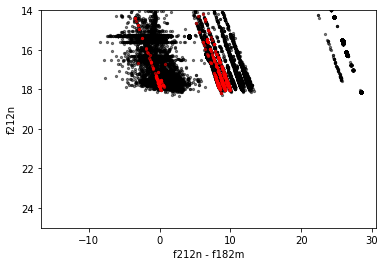

In [30]:
sel = reg.contains(basetable['skycoords_f212n'], ww)
pl.scatter(basetable['mag_ab_f212n'] - basetable['mag_ab_f182m'], basetable['mag_ab_f212n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f212n'] - basetable['mag_ab_f182m'])[sel], basetable['mag_ab_f212n'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f212n - f182m")
pl.ylabel("f212n")
pl.ylim(25,14)

In [31]:
import PIL
import pyavm

In [51]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_longwave_RGB_unrotated.png')
img = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_longwave_RGB_unrotated.png'))
#wwi = avm.to_wcs(use_full_header=True)
wwi = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

In [52]:
wwi

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 266.5356389808593  -28.712998625026  
CRPIX : 2829.531214097682  1167.45507920672  
PC1_1 PC1_2  : -0.01526213458185807  0.9998835268410042  
PC2_1 PC2_2  : 0.9998835268410042  0.01526213458185807  
CDELT : 1.74999921246059e-05  1.74999921246059e-05  
NAXIS : 5683  2329

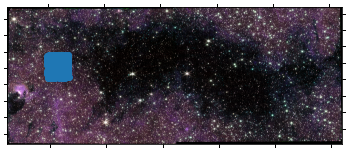

In [61]:
ax = pl.subplot(projection=wwi)
ax.imshow(img)
crds = basetable['skycoords_f410m']
ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('fk5'))

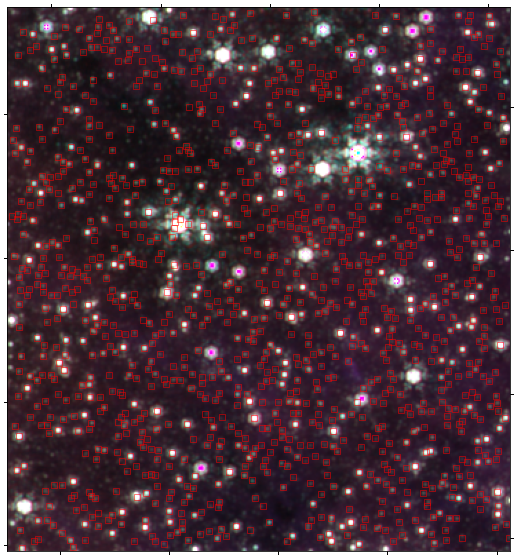

In [116]:
mask = reg.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
#co = np.array([mask.cutout(img[:,:,ii]) for ii in range(img.shape[2])])
co = img[slcs[0], slcs[1], :]

pl.figure(figsize=(10,10))
ax = pl.subplot(projection=wwi[slcs])
pl.imshow(co)

crds = basetable['skycoords_f410m']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
#sel = sel & (colorby > 2)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  edgecolor='r', facecolor='none', marker='s',
                  alpha=0.5)#r'$\rightarrow$')
                  #c=colorby[sel],
                  #norm=simple_norm(colorby[sel], stretch='linear',), cmap='jet')
#pl.draw()
#colors = scat.get_facecolors()
#scat.set_edgecolors(colors)
#scat.set_facecolors('none')

<SkyCoord (ICRS): (ra, dec) in deg
    (266.54178784, -28.74908469)>

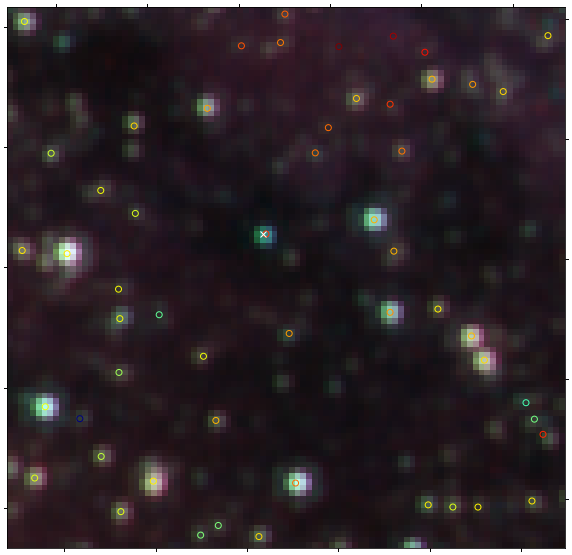

In [154]:
mask = regzoom.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
#co = np.array([mask.cutout(img[:,:,ii]) for ii in range(img.shape[2])])
co = img[slcs[0], slcs[1], :]

pl.figure(figsize=(10,10))
ax = pl.subplot(projection=wwi[slcs])
pl.imshow(co)

crds = basetable['skycoords_f410m']
sel = regzoom.contains(crds, ww410)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
#sel = sel & (colorby < -2)

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  #edgecolor='r', facecolor='none', marker='s')#r'$\rightarrow$')
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')
#pl.colorbar(mappable=scat)
ax.axis()
pl.plot(44,54, 'wx')
wwi[slcs].pixel_to_world(45,55)

In [139]:
import warnings

In [171]:
def starzoom(coords):
    reg = regions.RectangleSkyRegion(center=coords, width=1*u.arcsec, height=1*u.arcsec)
    ii = 0
    pl.figure(figsize=(12,4))
    filters_plotted = []
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for fn in sorted(glob.glob(f'{basepath}/F*/pipeline/*nircam*nrc*_i2d.fits')):
            filtername = fits.getheader(fn)['PUPIL']+fits.getheader(fn)['FILTER']
            if filtername in filters_plotted:
                continue
            ww = wcs.WCS(fits.getheader(fn, ext=('SCI',1)))
            if ww.footprint_contains(coords):
                print(fn)
                data = fits.getdata(fn, ext=('SCI',1))
                mask = reg.to_pixel(ww).to_mask()
                slcs,_ = mask.get_overlap_slices(data.shape)
                ax = pl.subplot(1,6,ii+1)
                ax.imshow(data[slcs], norm=simple_norm(data[slcs], stretch='asinh'),
                          origin='lower', cmap='gray')
                xx, yy = ww[slcs].world_to_pixel(coords)
                ax.plot(xx, yy, 'rx')
                ax.set_title(filtername)
                filters_plotted.append(filtername)
                ii += 1

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


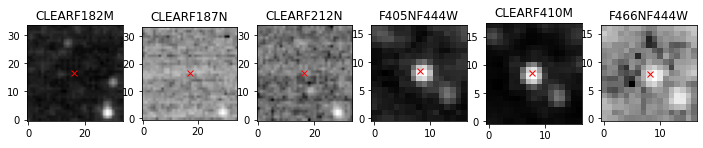

In [166]:
starzoom(coordinates.SkyCoord(266.54177, -28.74910, unit=(u.deg, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca2_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits


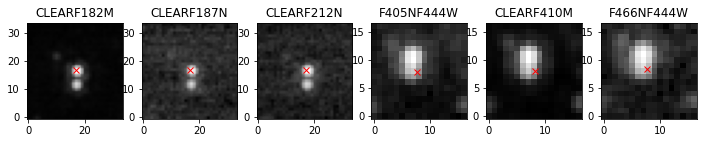

In [167]:
starzoom(coordinates.SkyCoord("17:46:10.006 -28:44:21.00", unit=(u.hour, u.deg), frame='icrs'))

/orange/adamginsburg/jwst/brick/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb3_i2d.fits
/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrcb_i2d.fits
/orange/adamginsburg/jwst/brick/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrcb_i2d.fits


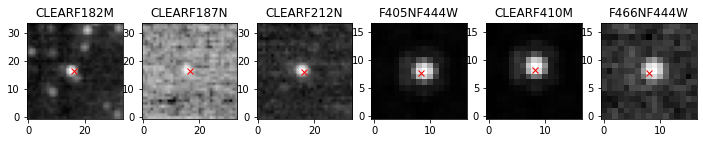

In [172]:
starzoom(coordinates.SkyCoord("17:46:10.682 -28:42:23.87", unit=(u.hour, u.deg), frame='icrs'))

In [39]:
fh = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits')
ww410 = wcs.WCS(fh[1].header)

Set DATE-AVG to '2022-08-28T03:05:31.909' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.654832 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526328725.126 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [40]:
ww410

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 266.535615939416  -28.737346514815  
CRPIX : 1439.318615916805  1145.909016366914  
PC1_1 PC1_2  : -0.01655757177857967  0.9998629140121146  
PC2_1 PC2_2  : 0.9998629140121146  0.01655757177857967  
CDELT : 1.74740513809727e-05  1.74740513809727e-05  
NAXIS : 2901  2297

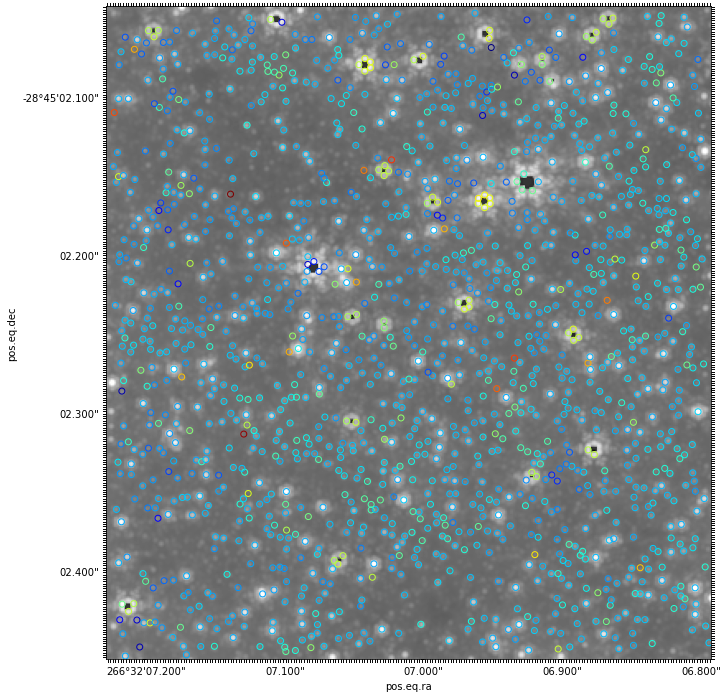

In [41]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410[slcs])
co = mask.cutout(fh['SCI'].data)
co = fh['SCI'].data[slcs]
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='linear',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=0.1 * u.arcsec)
lat.set_ticks(spacing=0.1 * u.arcsec)

In [42]:
tbls[0].meta

OrderedDict([('filename', 'F410M/f410m_nrca_crowdsource.fits'),
             ('filter', 'f410m'),
             ('pixelscale', <Quantity 3.05342472e-10 deg2>)])

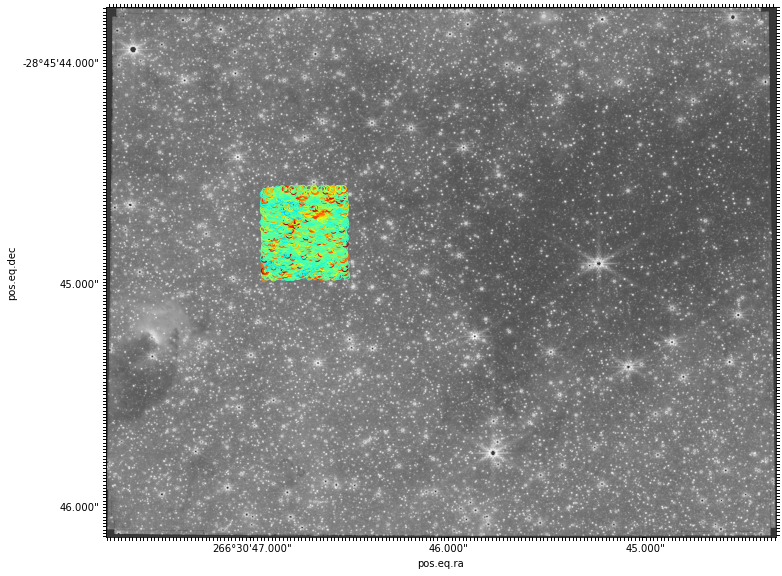

In [43]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410)
#ax = pl.gca()
co = fh['SCI'].data
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
#crds = tbls[0]['skycoords']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])
#scat = ax.scatter(xx, yy, c=basetable['flux_f410m'][sel],
#                  norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'), c=basetable['flux_f410m'][sel],
           norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=1 * u.arcsec)
lat.set_ticks(spacing=1 * u.arcsec)

(676.0, 1043.0, 1119.0, 1515.0)

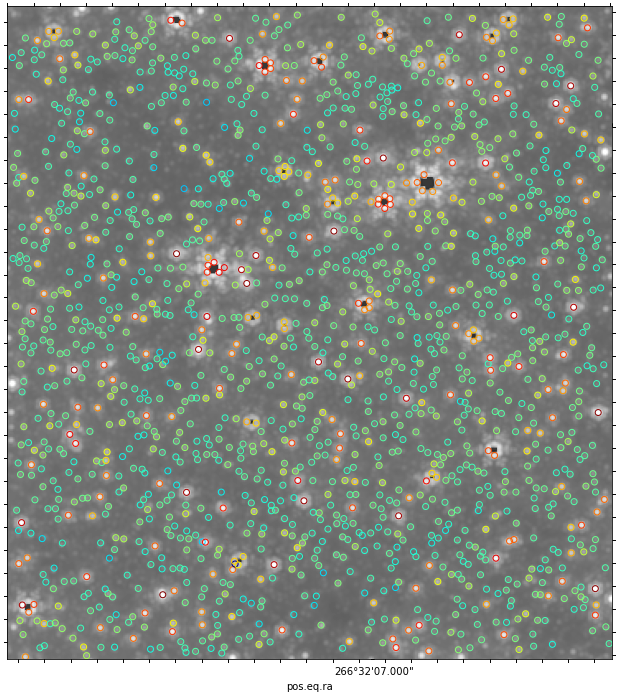

In [44]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410)
#ax = pl.gca()
co = fh['SCI'].data
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
#crds = tbls[0]['skycoords']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])
#scat = ax.scatter(xx, yy, c=basetable['flux_f410m'][sel],
#                  norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'), c=basetable['flux_f410m'][sel],
           norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=1 * u.arcsec)
lat.set_ticks(spacing=1 * u.arcsec)
ax.axis((676,1043,1119,1515))